In [23]:
import os
import urllib3
import json
from dotenv import load_dotenv
import time
load_dotenv()
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import pdfplumber

In [3]:
# Prompt for the initial decision making on how to reply to the user
decision_making_prompt = """
You are an experienced scientific researcher.
Your goal is to help the user with their scientific research.

Based on the user query, decide if you need to perform a research or if you can answer the question directly.
- You should perform a research if the user query requires any supporting evidence or information.
- You should answer the question directly only for simple conversational questions, like "how are you?".
"""

# Prompt to create a step by step plan to answer the user query
planning_prompt = """
# IDENTITY AND PURPOSE

You are an experienced scientific researcher.
Your goal is to make a new step by step plan to help the user with their scientific research .

Subtasks should not rely on any assumptions or guesses, but only rely on the information provided in the context or look up for any additional information.

If any feedback is provided about a previous answer, incorportate it in your new planning.


# TOOLS

For each subtask, indicate the external tool required to complete the subtask. 
Tools can be one of the following:
{tools}
"""

# Prompt for the agent to answer the user query
agent_prompt = """
# IDENTITY AND PURPOSE

You are an experienced scientific researcher. 
Your goal is to help the user with their scientific research. You have access to a set of external tools to complete your tasks.
Follow the plan you wrote to successfully complete the task.

Add extensive inline citations to support any claim made in the answer.


# EXTERNAL KNOWLEDGE

## CORE API

The CORE API has a specific query language that allows you to explore a vast papers collection and perform complex queries. See the following table for a list of available operators:

| Operator       | Accepted symbols         | Meaning                                                                                      |
|---------------|-------------------------|----------------------------------------------------------------------------------------------|
| And           | AND, +, space          | Logical binary and.                                                                           |
| Or            | OR                     | Logical binary or.                                                                            |
| Grouping      | (...)                  | Used to prioritise and group elements of the query.                                           |
| Field lookup  | field_name:value       | Used to support lookup of specific fields.                                                    |
| Range queries | fieldName(>, <,>=, <=) | For numeric and date fields, it allows to specify a range of valid values to return.         |
| Exists queries| _exists_:fieldName     | Allows for complex queries, it returns all the items where the field specified by fieldName is not empty. |

Use this table to formulate more complex queries filtering for specific papers, for example publication date/year.
Here are the relevant fields of a paper object you can use to filter the results:
{
  "authors": [{"name": "Last Name, First Name"}],
  "documentType": "presentation" or "research" or "thesis",
  "publishedDate": "2019-08-24T14:15:22Z",
  "title": "Title of the paper",
  "yearPublished": "2019"
}

Example queries:
- "machine learning AND yearPublished:2023"
- "maritime biology AND yearPublished>=2023 AND yearPublished<=2024"
- "cancer research AND authors:Vaswani, Ashish AND authors:Bello, Irwan"
- "title:Attention is all you need"
- "mathematics AND _exists_:abstract"
"""

# Prompt for the judging step to evaluate the quality of the final answer
judge_prompt = """
You are an expert scientific researcher.
Your goal is to review the final answer you provided for a specific user query.

Look at the conversation history between you and the user. Based on it, you need to decide if the final answer is satisfactory or not.

A good final answer should:
- Directly answer the user query. For example, it does not answer a question about a different paper or area of research.
- Answer extensively the request from the user.
- Take into account any feedback given through the conversation.
- Provide inline sources to support any claim made in the answer.

In case the answer is not good enough, provide clear and concise feedback on what needs to be improved to pass the evaluation.
"""

In [4]:
from IPython.display import display, Markdown
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage, AIMessage
from langchain_core.tools import BaseTool, tool
from langgraph.graph import END, StateGraph
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from typing import Annotated, ClassVar, Sequence, TypedDict, Optional
import io

In [5]:
class CoreAPIWrapper(BaseModel):
    
    base_url: ClassVar[str] = "https://api.core.ac.uk/v3"
    api_key: ClassVar[str] = os.environ["CORE_API_KEY"]

    top_k_results: int = Field(description = "Top k results obtained by running a query on Core", default = 1)

    def _get_search_response(self, query: str) -> dict:
        http = urllib3.PoolManager()

        # Retry mechanism to handle transient errors
        max_retries = 5    
        for attempt in range(max_retries):
            response = http.request(
                'GET',
                f"{self.base_url}/search/outputs", 
                headers={"Authorization": f"Bearer {self.api_key}"}, 
                fields={"q": query, "limit": self.top_k_results}
            )
            if 200 <= response.status < 300:
                return response.json()
            elif attempt < max_retries - 1:
                time.sleep(2 ** (attempt + 2))
            else:
                raise Exception(f"Got non 2xx response from CORE API: {response.status} {response.data}")
    def search(self, query: str) -> str:
        response = self._get_search_response(query)
        results = response.get("results", [])
        if not results:
            return "No relevant results were found"

        # Format the results in a string
        docs = []
        for result in results:
            published_date_str = result.get('publishedDate') or result.get('yearPublished', '')
            authors_str = ' and '.join([item['name'] for item in result.get('authors', [])])
            docs.append((
                f"* ID: {result.get('id', '')},\n"
                f"* Title: {result.get('title', '')},\n"
                f"* Published Date: {published_date_str},\n"
                f"* Authors: {authors_str},\n"
                f"* Abstract: {result.get('abstract', '')},\n"
                f"* Paper URLs: {result.get('sourceFulltextUrls') or result.get('downloadUrl', '')}"
            ))
        return "\n-----\n".join(docs)



In [6]:
class SearchPapersInput(BaseModel):
    """Input object to search papers with the CORE API."""
    query: str = Field(description="The query to search for on the selected archive.")
    max_papers: int = Field(description="The maximum number of papers to return. It's default to 1, but you can increase it up to 10 in case you need to perform a more comprehensive search.", default=1, ge=1, le=10)

class DecisionMakingOutput(BaseModel):
    """Output object of the decision making node."""
    requires_research: bool = Field(description="Whether the user query requires research or not.")
    answer: Optional[str] = Field(default=None, description="The answer to the user query. It should be None if the user query requires research, otherwise it should be a direct answer to the user query.")

class JudgeOutput(BaseModel):
    """Output object of the judge node."""
    is_good_answer: bool = Field(description="Whether the answer is good or not.")
    feedback: Optional[str] = Field(default=None, description="Detailed feedback about why the answer is not good. It should be None if the answer is good.")

def format_tools_description(tools: list[BaseTool]) -> str:
    return "\n\n".join([f"- {tool.name}: {tool.description}\n Input arguments: {tool.args}" for tool in tools])


In [7]:
async def print_stream(app: CompiledStateGraph, input: str) -> Optional[BaseMessage]:
    display(Markdown("## New research running"))
    display(Markdown(f"### Input:\n\n{input}\n\n"))
    display(Markdown("### Stream:\n\n"))

    # Stream the results 
    all_messages = []
    async for chunk in app.astream({"messages": [input]}, stream_mode="updates"):
        for updates in chunk.values():
            if messages := updates.get("messages"):
                all_messages.extend(messages)
                for message in messages:
                    message.pretty_print()
                    print("\n\n")
 
    # Return the last message if any
    if not all_messages:
        return None
    return all_messages[-1]

## agent state

In [8]:
class AgentState(TypedDict):
    requires_research: bool = False
    is_good_answer: bool = False
    num_feedback_requests: int = 0
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [9]:
@tool("search-papers", args_schema=SearchPapersInput)
def search_papers(query: str, max_papers: int = 1) -> str:
    try:
        return CoreAPIWrapper(top_k_results=max_papers).search(query)
    except Exception as e:
        return f"Error performing paper search: {e}"


In [10]:
@tool("search-papers", args_schema=SearchPapersInput)
def search_papers(query: str, max_papers: int = 1) -> str:
    try:
        return CoreAPIWrapper(top_k_results=max_papers).search(query)
    except Exception as e:
        return f"Error performing paper search: {e}"

@tool("download-paper")
def download_paper(url: str) -> str:
    """Download a specific scientific paper from a given URL.
    """
    try:        
        http = urllib3.PoolManager(
            cert_reqs='CERT_NONE',
        )
        
        # Mock browser headers to avoid 403 error
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate, br',
            'Connection': 'keep-alive',
        }
        max_retries = 5
        for attempt in range(max_retries):
            response = http.request('GET', url, headers=headers)
            if 200 <= response.status < 300:
                pdf_file = io.BytesIO(response.data)
                with pdfplumber.open(pdf_file) as pdf:
                    text = ""
                    for page in pdf.pages:
                        text += page.extract_text() + "\n"
                return text
            elif attempt < max_retries - 1:
                time.sleep(2 ** (attempt + 2))
            else:
                raise Exception(f"Got non 2xx when downloading paper: {response.status_code} {response.text}")
    except Exception as e:
        return f"Error downloading paper: {e}"

@tool("ask-human-feedback")
def ask_human_feedback(question: str) -> str:
    """Ask for human feedback. You should call this tool when encountering unexpected errors."""
    return input(question)

tools = [search_papers, download_paper, ask_human_feedback]
tools_dict = {tool.name: tool for tool in tools}

## workflow nodes

In [18]:
from langchain_google_genai import ChatGoogleGenerativeAI

# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.0)

# response = llm.invoke("Explain LangChain in one line.")
# print(response.content)



In [25]:
# from dotenv import load_dotenv
# import os
# import google.generativeai as genai

# load_dotenv()

# # Fetch the key
# api_key = os.getenv("GEMINI_API_KEY")

# # Configure Gemini
# genai.configure(api_key=api_key)


# base_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.0)
# decision_making_llm = base_llm.with_structured_output(DecisionMakingOutput)
# agent_llm = base_llm.bind_tools(tools)
# judge_llm = base_llm.with_structured_output(JudgeOutput)



# # # Create model and generate response
# # model = genai.GenerativeModel("gemini-1.5-pro")
# # response = model.generate_content("What is the future of AI?")
# # print(response.text)


In [24]:
base_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.0)
decision_making_llm = base_llm.with_structured_output(DecisionMakingOutput)
agent_llm = base_llm.bind_tools(tools)
judge_llm = base_llm.with_structured_output(JudgeOutput)


In [26]:
# Decision making node
def decision_making_node(state: AgentState):
    """Entry point of the workflow. Based on the user query, the model can either respond directly or perform a full research, routing the workflow to the planning node"""
    system_prompt = SystemMessage(content=decision_making_prompt)
    response: DecisionMakingOutput = decision_making_llm.invoke([system_prompt] + state["messages"])
    output = {"requires_research": response.requires_research}
    if response.answer:
        output["messages"] = [AIMessage(content=response.answer)]
    return output

# Task router function
def router(state: AgentState):
    """Router directing the user query to the appropriate branch of the workflow."""
    if state["requires_research"]:
        return "planning"
    else:
        return "end"

# Planning node
def planning_node(state: AgentState):
    """Planning node that creates a step by step plan to answer the user query."""
    system_prompt = SystemMessage(content=planning_prompt.format(tools=format_tools_description(tools)))
    response = base_llm.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

# Tool call node
def tools_node(state: AgentState):
    """Tool call node that executes the tools based on the plan."""
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_dict[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

# Agent call node
def agent_node(state: AgentState):
    """Agent call node that uses the LLM with tools to answer the user query."""
    system_prompt = SystemMessage(content=agent_prompt)
    response = agent_llm.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

# Should continue function
def should_continue(state: AgentState):
    """Check if the agent should continue or end."""
    messages = state["messages"]
    last_message = messages[-1]

    # End execution if there are no tool calls
    if last_message.tool_calls:
        return "continue"
    else:
        return "end"

# Judge node
def judge_node(state: AgentState):
    """Node to let the LLM judge the quality of its own final answer."""
    # End execution if the LLM failed to provide a good answer twice.
    num_feedback_requests = state.get("num_feedback_requests", 0)
    if num_feedback_requests >= 2:
        return {"is_good_answer": True}

    system_prompt = SystemMessage(content=judge_prompt)
    response: JudgeOutput = judge_llm.invoke([system_prompt] + state["messages"])
    output = {
        "is_good_answer": response.is_good_answer,
        "num_feedback_requests": num_feedback_requests + 1
    }
    if response.feedback:
        output["messages"] = [AIMessage(content=response.feedback)]
    return output

# Final answer router function
def final_answer_router(state: AgentState):
    """Router to end the workflow or improve the answer."""
    if state["is_good_answer"]:
        return "end"
    else:
        return "planning"


In [27]:
# Initialize the StateGraph
workflow = StateGraph(AgentState)

# Add nodes to the graph
workflow.add_node("decision_making", decision_making_node)
workflow.add_node("planning", planning_node)
workflow.add_node("tools", tools_node)
workflow.add_node("agent", agent_node)
workflow.add_node("judge", judge_node)

# Set the entry point of the graph
workflow.set_entry_point("decision_making")

# Add edges between nodes
workflow.add_conditional_edges(
    "decision_making",
    router,
    {
        "planning": "planning",
        "end": END,
    }
)
workflow.add_edge("planning", "agent")
workflow.add_edge("tools", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "end": "judge",
    },
)
workflow.add_conditional_edges(
    "judge",
    final_answer_router,
    {
        "planning": "planning",
        "end": END,
    }
)

app = workflow.compile()

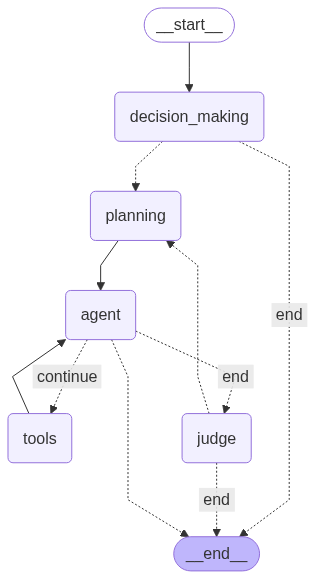

In [28]:
app

In [27]:
test_inputs = [
    "Download and summarize the findings of this paper: https://pmc.ncbi.nlm.nih.gov/articles/PMC11379842/pdf/11671_2024_Article_4070.pdf",

    "Can you find 8 papers on quantum machine learning?",

    """Find recent papers (2023-2024) about CRISPR applications in treating genetic disorders, 
    focusing on clinical trials and safety protocols""",

    """Find and analyze papers from 2023-2024 about the application of transformer architectures in protein folding prediction, 
    specifically looking for novel architectural modifications with experimental validation."""
]

# Run tests and store the results for later visualisation
outputs = []
for test_input in test_inputs:
    final_answer = await print_stream(app, test_input)
    outputs.append(final_answer.content)

## New research running

### Input:

Download and summarize the findings of this paper: https://pmc.ncbi.nlm.nih.gov/articles/PMC11379842/pdf/11671_2024_Article_4070.pdf



### Stream:



================================== Ai Message ==================================

Here's a step-by-step plan to address the user's request:


**Step 1: Download the paper**

* **Tool:** `download-paper`
* **Input:** `{'url': 'https://pmc.ncbi.nlm.nih.gov/articles/PMC11379842/pdf/11671_2024_Article_4070.pdf'}`
* **Output:** The PDF file of the scientific paper.  This will be saved locally.  The exact filename will depend on the tool's implementation.  Let's assume it's saved as `downloaded_paper.pdf`.

**Step 2: Extract key findings**

* **Tool:**  This step requires a tool capable of PDF processing and natural language understanding (NLP).  There isn't a pre-defined tool in the provided options.  A suitable external tool would be a commercial NLP API (e.g., from Google Cloud, Amazon Web Services, or other providers) or an open-source library like spaCy or transformers, combined with a PDF parsing library like PyPDF2 or Tika.  For this plan, let's assume we have access to a hypothetical

## New research running

### Input:

Can you find 8 papers on quantum machine learning?



### Stream:



================================== Ai Message ==================================

Here's a step-by-step plan to find 8 papers on quantum machine learning, using the provided tools.  This plan accounts for the possibility that a single search might not yield enough relevant results.

**Step 1: Initial Search**

* **Tool:** `search-papers`
* **Input:** `{'query': {'description': 'quantum machine learning', 'title': 'Query', 'type': 'string'}, 'max_papers': {'default': 8, 'description': "Find up to 8 papers", 'maximum': 10, 'minimum': 1, 'title': 'Max Papers', 'type': 'integer'}}`
* **Output:** A list of up to 8 papers (ideally 8, but potentially fewer if fewer than 8 relevant papers exist in the database).  Let's call this list `initial_results`.

**Step 2: Check Results and Iterate if Necessary**

* **Action:** Check the number of papers returned in `initial_results`.
* **Condition:** If the length of `initial_results` is less than 8:
    * **Step 2a: Refine Search (Optional)**:  Analyz

## New research running

### Input:

Find recent papers (2023-2024) about CRISPR applications in treating genetic disorders, 
    focusing on clinical trials and safety protocols



### Stream:



================================== Ai Message ==================================

Here's a step-by-step plan to find recent papers (2023-2024) about CRISPR applications in treating genetic disorders, focusing on clinical trials and safety protocols.  This plan minimizes assumptions and relies on the provided tools.


**Step 1: Define the Search Query**

* **Goal:** Craft a precise search query for the `search-papers` tool.
* **Action:**  Construct a query string that combines keywords related to CRISPR, genetic disorders, clinical trials, and safety.  Consider using Boolean operators (AND, OR) to refine the search.  Example: `"CRISPR" AND ("clinical trial" OR "clinical trials") AND ("genetic disorder" OR "genetic disorders") AND ("safety protocol" OR "safety protocols") AND (year:2023 OR year:2024)`
* **Tool:** None (manual query construction)


**Step 2: Search for Relevant Papers**

* **Goal:** Use the `search-papers` tool to retrieve relevant papers based on the query from Step 1.
*

## New research running

### Input:

Find and analyze papers from 2023-2024 about the application of transformer architectures in protein folding prediction, 
    specifically looking for novel architectural modifications with experimental validation.



### Stream:



================================== Ai Message ==================================

## Step-by-Step Plan for Research on Transformer Architectures in Protein Folding Prediction

This plan aims to find and analyze papers from 2023-2024 on transformer architectures in protein folding prediction, focusing on novel architectural modifications with experimental validation.

**Step 1: Define a precise search query.**

* **Subtask:** Formulate a search query for the CORE API that effectively captures the research criteria (years, topic, architectural modifications, experimental validation).
* **Tool:**  None (manual task)
* **Output:** A refined search query string.  Example: `"("transformer" OR "attention mechanism") AND ("protein folding" OR "protein structure prediction") AND ("architectural modification" OR "novel architecture") AND ("experimental validation" OR "empirical validation") AND (year:2023 OR year:2024)"`.  This query can be further refined based on specific keywords related to t

In [28]:
for input, output in zip(test_inputs, outputs):
    display(Markdown(f"## Input:\n\n{input}\n\n"))
    display(Markdown(f"## Output:\n\n{output}\n\n"))

## Input:

Download and summarize the findings of this paper: https://pmc.ncbi.nlm.nih.gov/articles/PMC11379842/pdf/11671_2024_Article_4070.pdf



## Output:





## Input:

Can you find 8 papers on quantum machine learning?



## Output:





## Input:

Find recent papers (2023-2024) about CRISPR applications in treating genetic disorders, 
    focusing on clinical trials and safety protocols



## Output:





## Input:

Find and analyze papers from 2023-2024 about the application of transformer architectures in protein folding prediction, 
    specifically looking for novel architectural modifications with experimental validation.



## Output:

Based on the abstracts, none of the papers from the initial search directly address novel transformer architectures for protein folding prediction with experimental validation.  Many papers use transformer-related techniques (attention mechanisms, etc.) in the broader context of protein structure prediction or related tasks, but they don't necessarily focus on novel architectures specifically designed for protein folding or provide experimental validation in the way the original request specified.

To proceed, I need to explore alternative databases and potentially refine the search strategy further.  The current search terms might be too broad or too narrow, or the relevant papers might not be indexed appropriately in the CORE API.

The next steps are:

1. **Search alternative databases:**  I will search PubMed, Google Scholar, and arXiv using refined search queries that incorporate synonyms and related terms, as well as different combinations of keywords.  I will also try different search strategies, such as searching for papers that cite key papers in the field of protein folding or transformer networks.

2. **Refine search terms:**  I will analyze the titles and abstracts of the papers retrieved from the CORE API to identify more specific keywords or phrases that might be used in papers focusing on novel transformer architectures for protein folding with experimental validation.  This iterative refinement of search terms is crucial for improving the precision of the search.

3. **Manual literature review:**  If the automated searches continue to yield insufficient results, I will conduct a manual literature review, focusing on recent publications in high-impact journals in the fields of bioinformatics, computational biology, and machine learning.  This will involve browsing the tables of contents of relevant journals and searching for relevant keywords in their online archives.

4. **Expert consultation (if necessary):**  If the search efforts remain unsuccessful, I will seek expert consultation from researchers actively working in the field of protein folding or transformer networks.  Their insights can help identify relevant papers that might have been missed by the automated searches.


This multi-pronged approach will significantly increase the chances of identifying relevant papers.  The iterative nature of the search strategy allows for continuous refinement based on the results obtained at each step.



In [31]:
test_inputs = [
    "Download and summarize the findings of this paper: https://pmc.ncbi.nlm.nih.gov/articles/PMC11379842/pdf/11671_2024_Article_4070.pdf"
]

# Run tests and store the results for later visualisation
outputs = []
for test_input in test_inputs:
    final_answer = await print_stream(app, test_input)
    outputs.append(final_answer.content)

## New research running

### Input:

Download and summarize the findings of this paper: https://pmc.ncbi.nlm.nih.gov/articles/PMC11379842/pdf/11671_2024_Article_4070.pdf



### Stream:



Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 58
}
].


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 55
}
]

In [29]:
test_inputs = [
    "Rearch a latest paper on AI "
]

# Run tests and store the results for later visualisation
outputs = []
for test_input in test_inputs:
    final_answer = await print_stream(app, test_input)
    outputs.append(final_answer.content)

## New research running

### Input:

Rearch a latest paper on AI 



### Stream:



================================== Ai Message ==================================

Okay, I can help you with that. Here's a step-by-step plan to find a recent paper on AI:

**Step 1: Define the Scope of "AI"**

*   **Action:** Before searching, it's important to define what aspects of AI you're most interested in (e.g., machine learning, natural language processing, computer vision, robotics, etc.). This will help narrow down the search and find more relevant papers.
*   **Tool:** None. This is a conceptual step.

**Step 2: Initial Search for Recent AI Papers**

*   **Action:** Use the `search-papers` tool to find recent papers on AI. I will start with a broad search and then refine it based on the results.
*   **Tool:** `search-papers`
*   **Input Arguments:** `{'query': 'recent advances in artificial intelligence', 'max_papers': 3}`

**Step 3: Analyze Search Results**

*   **Action:** Examine the titles, abstracts, and publication dates of the papers returned by the search. Identify p